In [29]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression

sns.set_style("darkgrid")

In [30]:
wx = pd.read_csv("weather.csv")
spray = pd.read_csv("spray.csv")
train = pd.read_csv("train.csv")
ss = pd.read_csv("sampleSubmission.csv")

In [31]:
train['Date'] = pd.to_datetime(train['Date'])

In [32]:
spray['Date'] = pd.to_datetime(spray['Date'])
spray['am_pm'] = spray['Time'].apply(lambda x: str(x).split()[-1])
spray['Time'] = spray['Time'].apply(lambda x: str(x).split()[0])

# spray['Time'] = pd.to_datetime(spray['Time'], format = '%H:%M:%S')

In [34]:
#converting Weather columns to datetime
wx['Date'] = pd.to_datetime(wx['Date'])

In [43]:
wx_sm = wx[['Date', 'Station', 'Tavg']].copy()

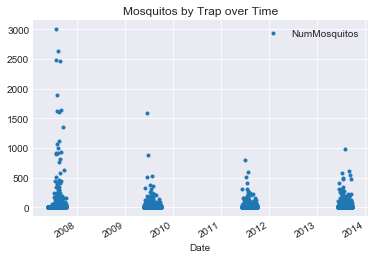

In [44]:
#plotted mosquitos by trap by date
train[['Date', 'Trap', 'NumMosquitos']].groupby(by = ['Date','Trap'])['Date','Trap','NumMosquitos'] \
    .sum().reset_index().sort_values('NumMosquitos', ascending = False).set_index('Date').plot(style = '.')
    
plt.title('Mosquitos by Trap over Time');

# Find closest Wx station

In [45]:
from haversine import haversine

In [46]:
len(train.Latitude.unique())

138

In [47]:
traps = train[['Trap', 'Latitude', 'Longitude']].drop_duplicates(['Trap']).reset_index(drop=True)

In [48]:
locations = []
for i in range(len(traps)):
    locations.append((traps['Latitude'][i], traps['Longitude'][i]))

In [49]:
ll = pd.Series(locations)
traps['Location'] = ll.values

In [50]:
traps.head()

,Trap,Latitude,Longitude,Location
0,T002,41.954690,-87.800991,"(41.95469, -87.800991)"
1,T007,41.994991,-87.769279,"(41.994991, -87.769279)"
2,T015,41.974089,-87.824812,"(41.974089, -87.824812)"
3,T045,41.921600,-87.666455,"(41.9216, -87.666455)"
4,T046,41.891118,-87.654491,"(41.891118, -87.65449100000001)"


In [51]:
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
st1 = (41.995, -87.933)

# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
st2 = (41.786, -87.752)

In [52]:
my_list = []
for location in locations:
    if haversine(st2, location) < haversine(st1, location):
        my_list.append(2)
    else:
        my_list.append(1)

print('# of st1:', my_list.count(1))
print('# of st2:', my_list.count(2))

# of st1: 39
# of st2: 97


In [53]:
import math

#initialize variables
radius = 6371 #km

def GCD(lat1,lon1,lat2,lon2):
    #code goes here
    sin1 = math.sin(math.radians(lat1))
    sin2 = math.sin(math.radians(lat2))
    cos1 = math.cos(math.radians(lat1))
    cos2 = math.cos(math.radians(lat2))
    dellon = math.cos(abs(math.radians(lon2-lon1)))
    
    delsigma = math.acos(sin1*sin2 + cos1*cos2*dellon)

    d = radius*delsigma
    return d


In [54]:
lat1 = 41.995
lat2 = 41.786
lon1 = -87.933
lon2 = -87.752

In [55]:
#calculate distance between trap and each Wx station, assign trap to closest station

train['Station'] = 1

for i in range(train.shape[0]):
    if GCD(lat1, lon1, train.loc[i, 'Latitude'], train.loc[i, 'Longitude']) > GCD(lat1, lon1, train.loc[i, 'Latitude'], train.loc[i, 'Longitude']):
        train.loc[i,'Station'] = 2

In [56]:
train = train.merge(wx_sm, how = 'left', on = ['Date','Station'])

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 14 columns):
Date                      10506 non-null datetime64[ns]
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
Station                   10506 non-null int64
Tavg                      10506 non-null object
dtypes: datetime64[ns](1), float64(2), int64(5), object(6)
memory usage: 1.2+ MB
